In [1]:
import warnings
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow import keras

import pandas as pd
warnings.filterwarnings("ignore")
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.2.0


# Reading the data




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#storing the details in the dataframe
image_list = []
path = './drive/My Drive/trafficsigns_dataset/*/*/*.png'
for filepath in glob.glob(path, recursive=True): 
    specific_type_label = filepath.split("/")[-2]
    shape_label = filepath.split("/")[-3]
    image_list.append((filepath, specific_type_label, shape_label))

# Create a data frame
image_df = pd.DataFrame(data=image_list, columns=['image_path', 'specific_type_label', 'shape_label'])
image_df.shape

(3699, 3)

# Data Exploration

### Randomly inspecting images

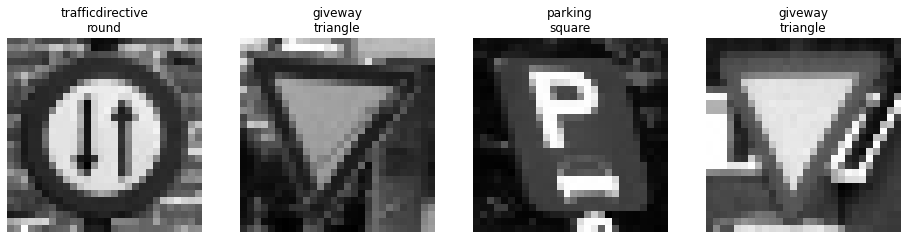

In [4]:
#randomly in inspecting loaded images with their labels

rand_data = image_df.sample(n=4, random_state=np.random.randint(100))
rand_data.reset_index(drop=True, inplace=True)

plt.figure(figsize=(16,4))
for i, row in rand_data.iterrows():
    im = np.asarray(Image.open(row.image_path))
    plt.subplot(1,4,i+1)
    plt.title(row.specific_type_label+"\n"+row.shape_label)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [5]:
#Checking the properites of the image
from random import randint
image = Image.open(image_df.loc[randint(1,3699),'image_path'])
print("Image Format :",image.format)
print("Image Mode :",image.mode)
print("Image Size :",image.size)

Image Format : PNG
Image Mode : L
Image Size : (28, 28)


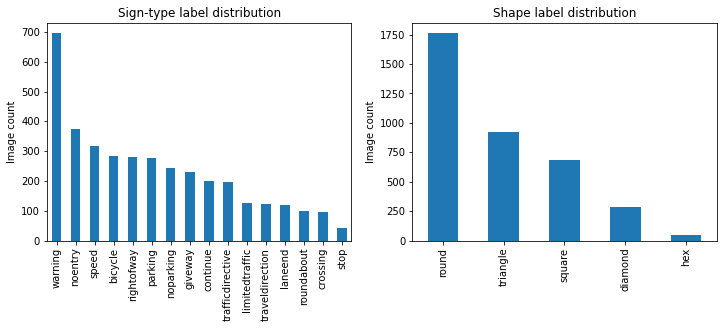

In [6]:

plt.figure(figsize=(12,4))
# plot for sign
plt.subplot(1,2,1)
ax = image_df['specific_type_label'].value_counts().plot(kind='bar',
                                                    title="Sign-type label distribution")
ax.set_ylabel('Image count')
# plot for shape
plt.subplot(1,2,2)
ax= image_df['shape_label'].value_counts().plot(kind='bar',
                                            title="Shape label distribution")
ax.set_ylabel('Image count')
plt.show()

# Splitting the data frame

#### Splitting for Sign-type classification





In [8]:
from sklearn.model_selection import train_test_split

sign_train, sign_test, sign_train_label, sign_test_label = train_test_split(image_df['image_path'], image_df['specific_type_label'], test_size=0.2, stratify=image_df['specific_type_label'], random_state=33)

sign_train, sign_val, sign_train_label, sign_val_label = train_test_split(sign_train, sign_train_label, test_size=0.25, stratify=sign_train_label, random_state=1) # 0.25 x 0.8 = 0.2

print("For sign classification, splits are as below")
print("\nTraining data count: {} - size: {}%".format(len(sign_train),(round(len(sign_train)/len(image_df)*100))))
print("\nValidation data count: {} - size: {}%".format(len(sign_val),(round(len(sign_val)/len(image_df)*100))))
print("\nTesting data count: {} - size: {}%".format(len(sign_test),(round(len(sign_test)/len(image_df)*100))))

sign_train_df = pd.DataFrame(list(zip(sign_train, sign_train_label)),columns=['image_path','sign_train_label'])
sign_val_df = pd.DataFrame(list(zip(sign_val, sign_val_label)),columns=['image_path','sign_val_label'])
sign_test_df = pd.DataFrame(list(zip(sign_test, sign_test_label)),columns=['image_path','sign_test_label'])

For sign classification, splits are as below

Training data count: 2219 - size: 60%

Validation data count: 740 - size: 20%

Testing data count: 740 - size: 20%


#### Splitting for shape-type classification

In [9]:
from sklearn.model_selection import train_test_split

shape_train, shape_test, shape_train_label, shape_test_label = train_test_split(image_df['image_path'], image_df['shape_label'], test_size=0.2, stratify=image_df['shape_label'], random_state=62)

shape_train, shape_val, shape_train_label, shape_val_label = train_test_split(shape_train, shape_train_label, test_size=0.25, stratify=shape_train_label, random_state=1) # 0.25 x 0.8 = 0.2

print("For shape classification, splits are as below")
print("\nTraining data count: {} - size: {}%".format(len(shape_train),(round(len(shape_train)/len(image_df)*100))))
print("\nValidation data count: {} - size: {}%".format(len(shape_val),(round(len(shape_val)/len(image_df)*100))))
print("\nTesting data count: {} - size: {}%".format(len(shape_test),(round(len(shape_test)/len(image_df)*100))))

shape_train_df = pd.DataFrame(list(zip(shape_train, shape_train_label)),columns=['image_path','shape_train_label'])
shape_val_df = pd.DataFrame(list(zip(shape_val, shape_val_label)),columns=['image_path','shape_val_label'])
shape_test_df = pd.DataFrame(list(zip(shape_test, shape_test_label)),columns=['image_path','shape_test_label'])

For shape classification, splits are as below

Training data count: 2219 - size: 60%

Validation data count: 740 - size: 20%

Testing data count: 740 - size: 20%


## Defining ImageDataGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_data_generator(train_df,val_df,augment=False):

    if augment:
      train_ds = ImageDataGenerator(
          rescale=1./255., 
          data_format='channels_last',
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          brightness_range=[0.2,1.0],
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
    else:
         train_ds = ImageDataGenerator(
          rescale=1./255., 
          data_format='channels_last')
    
    val_ds = ImageDataGenerator(rescale=1./255., data_format='channels_last')

    batch_size = 32
    image_size = (28, 28)
    
    image_path = train_df.columns[0] #same column name is used for test and val
    train_label = train_df.columns[1]
    val_label = val_df.columns[1]

    train_generator = train_ds.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col=image_path,
            y_col=train_label,
            target_size= image_size,
            batch_size=batch_size,
            seed=1337,
            color_mode= "grayscale",
            class_mode='categorical')

    validation_generator = val_ds.flow_from_dataframe(
            dataframe=val_df,
            directory=None,
            x_col=image_path,
            y_col=val_label,
            target_size= image_size,
            batch_size= batch_size,
            seed=1337,
            color_mode= "grayscale",
            class_mode='categorical')
    return train_generator, validation_generator

# Models

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD


# define cnn model
def define_model(label_count):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(label_count, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# Function to plot Epochs vs Accuracy and Epochs vs Loss for the trained model
# Input : history object returned from the fit function
# Output : None, plots two graphs

import matplotlib.pyplot as plt

# plot diagnostic learning curves
def summarize_diagnostics(history):
      # summarize history for accuracy
      plt.figure(figsize=(12,4))
      plt.subplot(1,2,1)
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'])
      # summarize history for loss
      plt.subplot(1,2,2)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'])
      plt.show()

In [0]:
# Function to train the model
# Input : train data, validation data, CNN model and epochs
# Output : history object returned from the fit function

from collections import Counter

def train_model (train_data, val_data, model, epochs = 50):
    
    count_of_classes = Counter(train_data.classes)
    max_count = float(sum(count_of_classes.values())/len(count_of_classes.values()))
    class_weights = {label : max_count/num_of_Img for label, num_of_Img in count_of_classes.items()}


    callbacks = [
        keras.callbacks.ModelCheckpoint("/model/save_at_{epoch}.h5") 
    ]

    model_history = model.fit(
        train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data, class_weight = class_weights
    )
    return model_history

## Baseline Model with unchanged data shape classification.

In [14]:
# Data for shape classification
train_data, val_data = image_data_generator(shape_train_df,shape_val_df,augment=False)

#define the model
shape_model = define_model(5)
shape_model.summary()

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_

In [15]:
shape_model_history = train_model(train_data,val_data, shape_model, 60)
shape_model.save_weights('shape_model.h5') 

Epoch 1/60
70/70 [==============================] - 4s 56ms/step - loss: 1.4901 - accuracy: 0.3475 - val_loss: 1.1231 - val_accuracy: 0.7500
Epoch 2/60
70/70 [==============================] - 4s 52ms/step - loss: 0.7045 - accuracy: 0.6827 - val_loss: 0.7134 - val_accuracy: 0.7189
Epoch 3/60
70/70 [==============================] - 4s 53ms/step - loss: 0.4172 - accuracy: 0.8184 - val_loss: 0.5000 - val_accuracy: 0.8243
Epoch 4/60
70/70 [==============================] - 4s 53ms/step - loss: 0.1734 - accuracy: 0.9360 - val_loss: 0.2086 - val_accuracy: 0.9378
Epoch 5/60
70/70 [==============================] - 4s 53ms/step - loss: 0.1016 - accuracy: 0.9667 - val_loss: 0.2116 - val_accuracy: 0.9419
Epoch 6/60
70/70 [==============================] - 4s 54ms/step - loss: 0.0686 - accuracy: 0.9797 - val_loss: 0.1439 - val_accuracy: 0.9581
Epoch 7/60
70/70 [==============================] - 4s 53ms/step - loss: 0.0473 - accuracy: 0.9838 - val_loss: 0.2043 - val_accuracy: 0.9392
Epoch 8/60
70

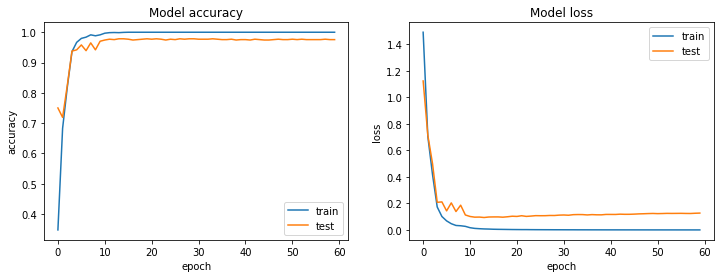

In [16]:
summarize_diagnostics(shape_model_history)

## Baseline Model with augmented data for shape classification

In [17]:
#Define the model
shape_aug_data_model = define_model(5)

#prepare the data
train_aug_data, val_data = image_data_generator(shape_train_df,shape_val_df,augment=True)

#train the data
shape_aug_model_history = train_model(train_aug_data, val_data, shape_aug_data_model,60)
shape_aug_data_model.save_weights('shape_aug_data_model.h5')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Epoch 1/60
70/70 [==============================] - 5s 72ms/step - loss: 1.6229 - accuracy: 0.2114 - val_loss: 1.6390 - val_accuracy: 0.2216
Epoch 2/60
70/70 [==============================] - 5s 70ms/step - loss: 1.5680 - accuracy: 0.2105 - val_loss: 1.5413 - val_accuracy: 0.2041
Epoch 3/60
70/70 [==============================] - 5s 71ms/step - loss: 1.4826 - accuracy: 0.3173 - val_loss: 1.3162 - val_accuracy: 0.5081
Epoch 4/60
70/70 [==============================] - 5s 70ms/step - loss: 1.3920 - accuracy: 0.3804 - val_loss: 1.7460 - val_accuracy: 0.2378
Epoch 5/60
70/70 [==============================] - 5s 70ms/step - loss: 1.2359 - accuracy: 0.4092 - val_loss: 1.0454 - val_accuracy: 0.5770
Epoch 6/60
70/70 [==============================] - 5s 71ms/step - loss: 1.2007 - accuracy: 0.4552 - val_loss: 0.6853 - val_accuracy: 0.7878
Epoch 7/60
70/70 [===============

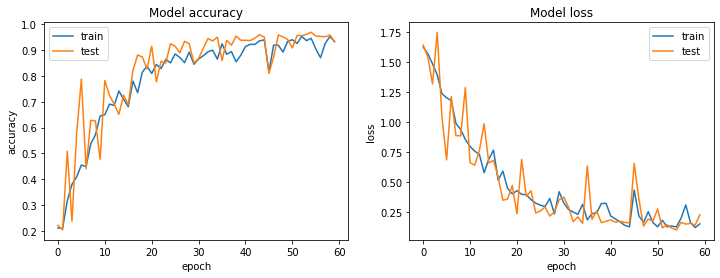

In [18]:
summarize_diagnostics(shape_aug_model_history)

## Baseline Model with unchanged data for sign classification

In [19]:
#create the model
sign_model = define_model(16)
sign_model.summary()

# prepare the data
sign_train_data, sign_val_data = image_data_generator(sign_train_df,sign_val_df,augment=False)

#train the data
sign_model_history = train_model(sign_train_data, sign_val_data, sign_model, 60)
sign_model.save_weights('sign_model.h5') 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)        

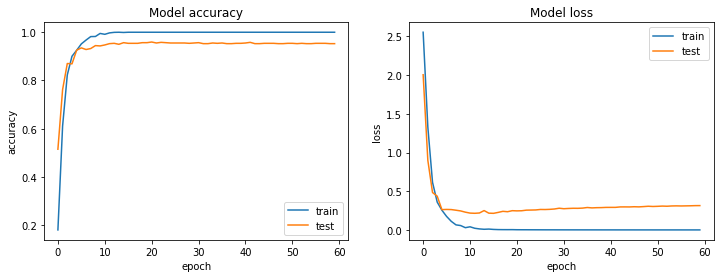

In [20]:
summarize_diagnostics(sign_model_history)

## Baseline model with augmented data for sign classification

In [21]:
#define the model
sign_aug_data_model = define_model(16)

# Prepare the data
train_aug_data, val_data = image_data_generator(sign_train_df,sign_val_df,augment=True)

# Train the model
sign_aug_model_history = train_model(train_aug_data, val_data, sign_aug_data_model, 60)
sign_aug_data_model.save_weights('sign_aug_data_model.h5') 

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/60
70/70 [==============================] - 5s 70ms/step - loss: 2.7590 - accuracy: 0.0757 - val_loss: 2.5775 - val_accuracy: 0.2230
Epoch 2/60
70/70 [==============================] - 5s 68ms/step - loss: 2.5996 - accuracy: 0.1600 - val_loss: 2.3248 - val_accuracy: 0.2338
Epoch 3/60
70/70 [==============================] - 5s 68ms/step - loss: 2.3709 - accuracy: 0.2370 - val_loss: 1.9728 - val_accuracy: 0.3676
Epoch 4/60
70/70 [==============================] - 5s 67ms/step - loss: 2.1489 - accuracy: 0.2956 - val_loss: 1.8442 - val_accuracy: 0.4405
Epoch 5/60
70/70 [==============================] - 5s 69ms/step - loss: 1.9750 - accuracy: 0.3840 - val_loss: 1.4342 - val_accuracy: 0.5649
Epoch 6/60
70/70 [==============================] - 5s 69ms/step - loss: 1.7618 - accuracy: 0.4389 - val_loss: 1.0953 - val_accuracy: 0.6608
Epoch 7/60
70/70 [=============

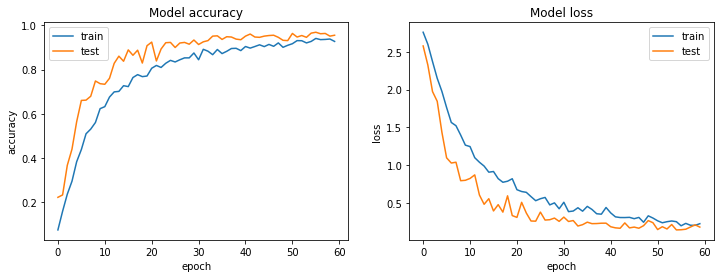

In [22]:
summarize_diagnostics(sign_aug_model_history)

# Testing the data with the best model for sign classification

Found 740 validated image filenames belonging to 16 classes.

# Evaluate on test data
12/12 [==============================] - 1s 61ms/step - loss: 0.2176 - accuracy: 0.9608
Prediction accuracy: 96.08% 


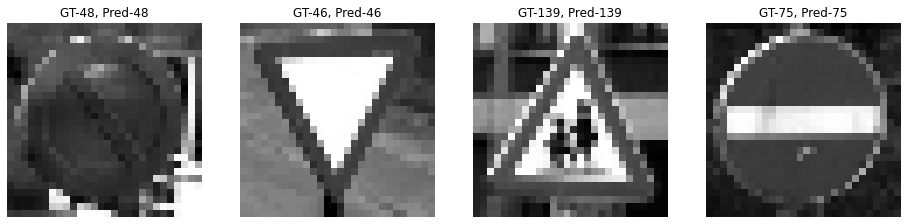

In [24]:
test_ds = ImageDataGenerator(rescale=1./255., data_format='channels_last')

test_generator = test_ds.flow_from_dataframe(
            dataframe=sign_test_df,
            directory=None,
            x_col="image_path",
            y_col="sign_test_label",
            target_size= (28, 28),
            batch_size= 64,
            seed=93,
            color_mode= "grayscale",
            class_mode='categorical')

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = sign_aug_data_model.evaluate(test_generator, batch_size=64)
print('Prediction accuracy: {}% '.format(round(results[1]*100,2)))

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

from collections import Counter

d_inv = {k: v for k, v in (Counter(test_generator.classes)).items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_hat = sign_aug_data_model.predict(x, verbose=0)
    x = np.squeeze(x)
    x = x[0,:,:]
    if batches < 5:
        plt.subplot(1,4,batches)
        plt.imshow(x,cmap="gray")
        plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))          
    else:
        break     

    plt.axis('off')

# Testing the data with the best model for shape classification

Found 740 validated image filenames belonging to 5 classes.

# Evaluate on test data
12/12 [==============================] - 1s 69ms/step - loss: 0.1428 - accuracy: 0.9595
Prediction accuracy: 95.95% 


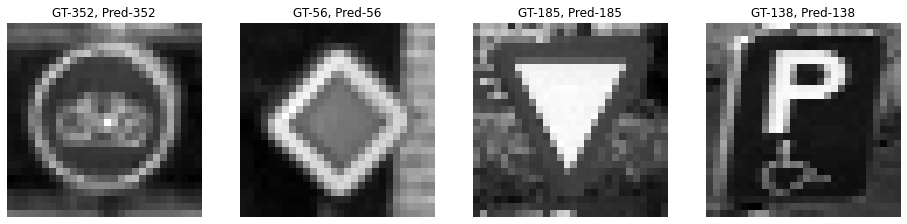

In [25]:
test_ds = ImageDataGenerator(rescale=1./255., data_format='channels_last')

shape_test_generator = test_ds.flow_from_dataframe(
            dataframe=shape_test_df,
            directory=None,
            x_col="image_path",
            y_col="shape_test_label",
            target_size= (28, 28),
            batch_size= 64,
            seed=92,
            color_mode= "grayscale",
            class_mode='categorical')

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = shape_aug_data_model.evaluate(shape_test_generator, batch_size=64)
print('Prediction accuracy: {}% '.format(round(results[1]*100,2)))



from collections import Counter

d_inv = {k: v for k, v in (Counter(shape_test_generator.classes)).items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in shape_test_generator:
        batches = batches + 1
        y_hat = shape_aug_data_model.predict(x, verbose=0)
        x = np.squeeze(x)
        x = x[0,:,:]
        if batches < 5:
            plt.subplot(1,4,batches)
            plt.imshow(x,cmap="gray")
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))          
        else:
            break   

        plt.axis('off')

# Independent evaluation

In [26]:
#storing the details in the dataframe
image_list = []
path = './drive/My Drive/Independent evaluation/*/*'
for filepath in glob.glob(path, recursive=True): 
    labels = filepath.split("/")[-2]
    sign_label = labels.split("-")[-1]
    shape_label = labels.split("-")[-2]
    image_list.append((filepath, sign_label, shape_label))

# Create a data frame
ind_image_df = pd.DataFrame(data=image_list, columns=['image_path', 'sign_label', 'shape_label'])
ind_image_df.shape

(118, 3)

## Sign-type classification

Found 117 validated image filenames belonging to 16 classes.

# Evaluate on test data
2/2 [==============================] - 0s 74ms/step - loss: 3.0486 - accuracy: 0.6581
Prediction accuracy: 65.81% 


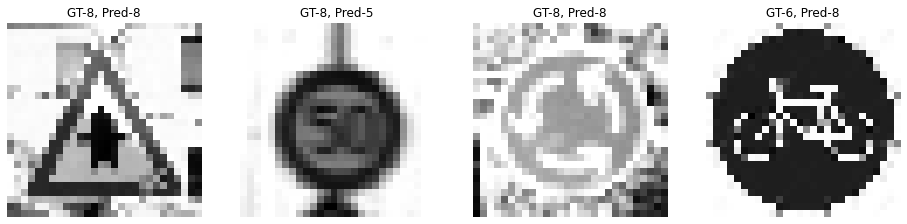

In [27]:
test_ds = ImageDataGenerator(rescale=1./255., data_format='channels_last')

sign_test_generator = test_ds.flow_from_dataframe(
            dataframe=ind_image_df,
            directory=None,
            x_col="image_path",
            y_col="sign_label",
            target_size= (28, 28),
            batch_size= 64,
            seed=44,
            color_mode= "grayscale",
            class_mode='categorical')

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = sign_aug_data_model.evaluate(sign_test_generator, batch_size=64)
print('Prediction accuracy: {}% '.format(round(results[1]*100,2)))



from collections import Counter

d_inv = {k: v for k, v in (Counter(sign_test_generator.classes)).items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in sign_test_generator:
        batches = batches + 1
        y_hat = sign_aug_data_model.predict(x, verbose=0)
        x = np.squeeze(x)
        x = x[0,:,:]
        if batches < 5:
            plt.subplot(1,4,batches)
            plt.imshow(x,cmap="gray")
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))          
        else:
            break   

        plt.axis('off')

## Shape-type classification

Found 117 validated image filenames belonging to 5 classes.

# Evaluate on test data
2/2 [==============================] - 0s 56ms/step - loss: 1.9859 - accuracy: 0.7949
Prediction accuracy: 79.49% 


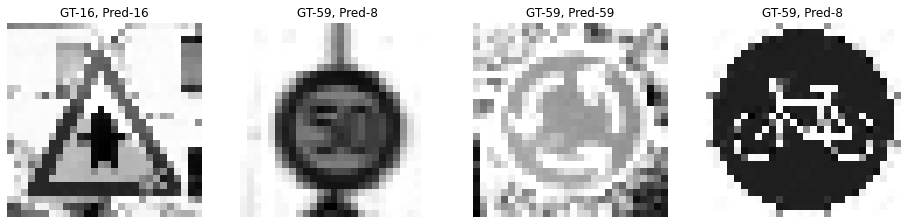

In [28]:
test_ds = ImageDataGenerator(rescale=1./255., data_format='channels_last')

shape_test_generator = test_ds.flow_from_dataframe(
            dataframe=ind_image_df,
            directory=None,
            x_col="image_path",
            y_col="shape_label",
            target_size= (28, 28),
            batch_size= 64,
            seed=44,
            color_mode= "grayscale",
            class_mode='categorical')

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = shape_aug_data_model.evaluate(shape_test_generator, batch_size=64)
print('Prediction accuracy: {}% '.format(round(results[1]*100,2)))



from collections import Counter

d_inv = {k: v for k, v in (Counter(shape_test_generator.classes)).items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in shape_test_generator:
        batches = batches + 1
        y_hat = shape_aug_data_model.predict(x, verbose=0)
        x = np.squeeze(x)
        x = x[0,:,:]
        if batches < 5:
            plt.subplot(1,4,batches)
            plt.imshow(x,cmap="gray")
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))          
        else:
            break   

        plt.axis('off')

# Best model representation

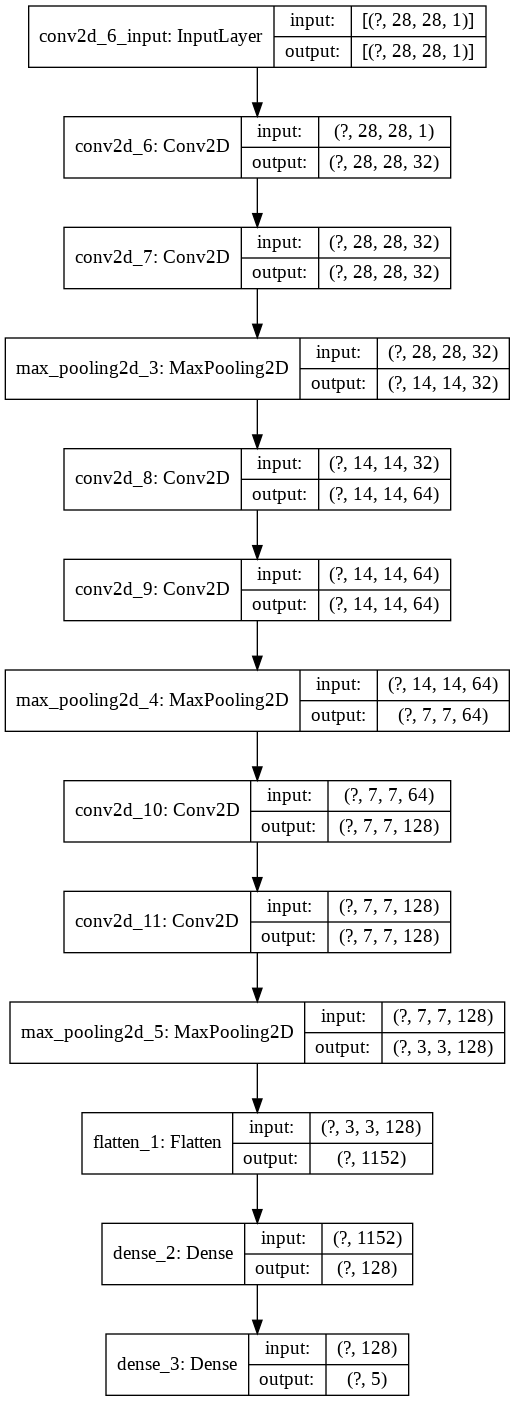

In [29]:
keras.utils.plot_model(shape_aug_data_model, show_shapes=True)

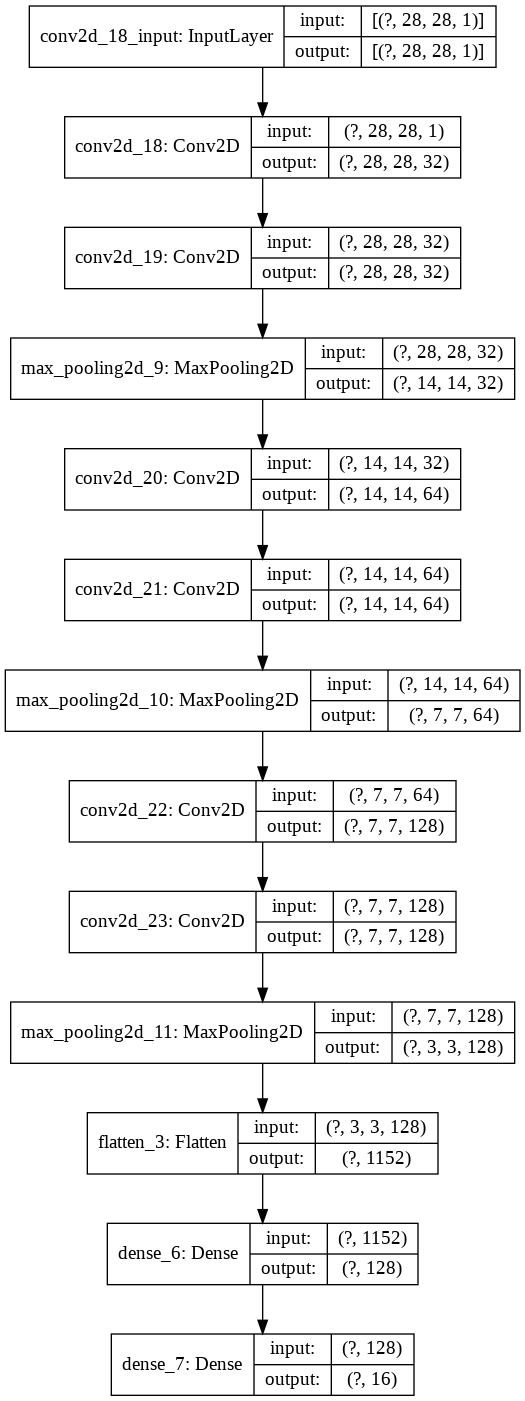

In [32]:
keras.utils.plot_model(sign_aug_data_model, show_shapes=True)